# Spin Wave Simulation

Instrument: ARCS
* Ei=100meV
* Fermi chopper: 600 Hz
* T0: 120Hz
 
Sample: some crystal
* lattice parameters: 2, 2.5, 3        90 90 90
* spin wave: E = 80 * | sin($\pi$h) |
* new spin wave: (from Mourigal paper: quantum AF on square lattice)
* Orientation: u,v = [1 0 2] and  [1 0 0]
* psi angles: -90, 90, step 3


## Step 0. some goodies

In [2]:
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np
import histogram.hdf as hh, histogram as H

## Step 1. create dir structure

In [3]:
# Change this!!!
# workdir = "/SNS/users/lj7/simulations/ARCS/spinwave-demo/"
workdir = "/SNS/users/p63/mcvine/mourigal-square-QM-AF/"
!mkdir -p {workdir}

In [4]:
%cd {workdir}
!ls

/SNS/users/p63/mcvine/mourigal-square-QM-AF


In [5]:
!mkdir -p samples/X/sampleassembly
!mkdir -p beam
!mkdir -p scattering

In [6]:
!find .

.
./samples
./samples/X
./samples/X/sampleassembly
./beam
./scattering


## Step 2. obtain beam simulation

In [11]:
cd {workdir}

/SNS/users/p63/mcvine/mourigal-square-QM-AF


In [12]:
!find .

.
./samples
./samples/X
./samples/X/sampleassembly
./beam
./beam/100meV
./scattering


In [13]:
!ln -s /SNS/users/lj7/simulations/ARCS/beam/100meV beam/100meV

ln: failed to create symbolic link ‘beam/100meV/100meV’: Permission denied


In [14]:
%cd beam/100meV

/SNS/users/lj7/simulations/ARCS/beam/100meV


In [58]:
# check
import histogram.hdf as hh
ie = hh.load("out/ienergy.h5")
plt.plot(ie.energy, ie.I)

/SNS/users/lj7/software/miniconda2/envs/mcvine/lib/python2.7/site-packages/histogram/hdf/__init__.py:55: UserWarning: filename as url is deprecated
  warnings.warn("filename as url is deprecated")


ValueError: out/ienergy.h5

## Step 3. Create sample assembly

In [16]:
%cd "{workdir}/samples/X/sampleassembly"

/SNS/users/p63/mcvine/mourigal-square-QM-AF/samples/X/sampleassembly


In [17]:
%cp -a /SNS/users/lj7/simulations/samples/spinwave/* .

NOTE: xyz data needed if I want to add phonon kernels

In [18]:
%%file ./X.xyz
8
3 0 0    0 3 0    0 0 3
V 0 0 0
V 0 0 0
V 0 0 0
V 0 0 0
V 0 0 0
V 0 0 0
V 0 0 0
V 0 0 0


Overwriting ./X.xyz


In [19]:
%%file ./X-scatterer.xml
<?xml version="1.0"?>

<!DOCTYPE scatterer>

<!-- weights: absorption, scattering, transmission -->
<homogeneous_scatterer 
  mcweights="0, 1, 0.1"
  <!--
    mcweights not needed for multiple scattering simulations
    -->
  max_multiplescattering_loops="3"
  >
  
  <KernelContainer average="yes">
    
    <E_Q_Kernel 
	E_Q="0" 
	S_Q="1"
	Qmin="0./angstrom"
	Qmax="16./angstrom"
	/>
    
    <E_vQ_Kernel 
	<!--E_Q="pi:=3.1415926535897932; twopi:=2*pi; a:=2; b:=2.5; c:=3; 
    h:=a*Qx/twopi; k:=b*Qy/twopi; l:=c*Qz/twopi; 
    cospih2:=cos(h*pi)^2; cospil2:=cos(l*pi)^2; cospik2:=cos(k*pi)^2; 
    (80.^2*(1-cospih2)) ^ (0.5)"
    -->
    E_Q="pi:=3.1415926535897932; twopi:=2*pi; a:=3; b:=3; c:=3; 
    h:=a*Qx/twopi; k:=b*Qy/twopi; l:=c*Qz/twopi;
    gamma_k:=0.5*(cos(2*pi*h)+cos(2*pi*k));
    40*sqrt((1+gamma_k)*(1-cos((pi/4)*gamma_k)))"
	S_Q="1"
	Emax="81*meV"
	/>
    
  </KernelContainer>
  
</homogeneous_scatterer>

Overwriting ./X-scatterer.xml


In [20]:
a,b,c=3,3,3

from numpy import sin, cos, deg2rad
a1 = [a, 0, 0]
a2 = [0, b, 0]
a3 = [0, 0, c]

twopi = 2*np.pi
f = twopi/np.dot(a1, np.cross(a2, a3))
b1 = np.cross(a2,a3) * f
b2 = np.cross(a3,a1) * f
b3 = np.cross(a1,a2) * f
b1,b2,b3

(array([ 2.0943951,  0.       ,  0.       ]),
 array([ 0.       ,  2.0943951,  0.       ]),
 array([ 0.       ,  0.       ,  2.0943951]))

#### Orientation of the kernel
Here we need to use the convention that z is along beam, y vertical up.
The kernel has its own cartesian axis e’x e’y e’z. Because we know
u = 102 v = 100
, we have the basis vectors of the instrument coordinate system

    ez along b1 + 2*b3
    ex along b1
    

So we have them in the reciprocal cartesian axis

In [22]:
ez = b1 + 2*b3; ez /= np.linalg.norm(ez)
ex1 = b1
ey = np.cross(ez, ex1); ey/=np.linalg.norm(ey)
ex = np.cross(ey, ez)
ex, ey, ez

(array([ 0.89442719,  0.        , -0.4472136 ]),
 array([ 0.,  1.,  0.]),
 array([ 0.4472136 ,  0.        ,  0.89442719]))

The rotation matrix is define as
```
    ex.ex’ ex.ey’ ex.ez’ 
R = ey.ex’ ey.ey’ ey.ez’
    ez.ex’ ez.ey’ ez.ez’
```
So

In [23]:
R = np.array([ ex, ey, ez ])
Rflat = R.copy(); Rflat.shape = -1,
R, Rflat

(array([[ 0.89442719,  0.        , -0.4472136 ],
        [ 0.        ,  1.        ,  0.        ],
        [ 0.4472136 ,  0.        ,  0.89442719]]),
 array([ 0.89442719,  0.        , -0.4472136 ,  0.        ,  1.        ,
         0.        ,  0.4472136 ,  0.        ,  0.89442719]))

Now we add an extra kernel parameter:

In [24]:
'orientation="%s"' % (','.join(str(e) for e in Rflat),)

'orientation="0.894427191,0.0,-0.4472135955,0.0,1.0,0.0,0.4472135955,0.0,0.894427191"'

In [ ]:
# modify X-scatterer.xml to specify the orientation

In [26]:
%%file ./X-scatterer.xml
<?xml version="1.0"?>

<!DOCTYPE scatterer>

<!-- weights: absorption, scattering, transmission -->
<homogeneous_scatterer 
  mcweights="0, 1, 0.1"
  max_multiplescattering_loops="3"
  >
  
  <KernelContainer average="yes">
    
    <E_Q_Kernel 
	E_Q="0" 
	S_Q="1"
	Qmin="0./angstrom"
	Qmax="16./angstrom"
	/>
    
    <E_vQ_Kernel 
	E_Q="pi:=3.1415926535897932; twopi:=2*pi; a:=3; b:=3; c:=3; 
    h:=a*Qx/twopi; k:=b*Qy/twopi; l:=c*Qz/twopi;
    gamma_k:=0.5*(cos(2*pi*h)+cos(2*pi*k));
    40*sqrt((1+gamma_k)*(1-cos((pi/4)*gamma_k)))"
	S_Q="1"
	Emax="81*meV"
	orientation="0.894427191,0.0,-0.4472135955,0.0,1.0,0.0,0.4472135955,0.0,0.894427191"
	/>
    
  </KernelContainer>
  
</homogeneous_scatterer>

Overwriting ./X-scatterer.xml


In [27]:
!cat X-scatterer.xml

<?xml version="1.0"?>

<!DOCTYPE scatterer>

<!-- weights: absorption, scattering, transmission -->
<homogeneous_scatterer 
  mcweights="0, 1, 0.1"
  max_multiplescattering_loops="3"
  >
  
  <KernelContainer average="yes">
    
    <E_Q_Kernel 
	E_Q="0" 
	S_Q="1"
	Qmin="0./angstrom"
	Qmax="16./angstrom"
	/>
    
    <E_vQ_Kernel 
	E_Q="pi:=3.1415926535897932; twopi:=2*pi; a:=3; b:=3; c:=3; 
    h:=a*Qx/twopi; k:=b*Qy/twopi; l:=c*Qz/twopi;
    gamma_k:=0.5*(cos(2*pi*h)+cos(2*pi*k));
    40*sqrt((1+gamma_k)*(1-cos((pi/4)*gamma_k)))"
	S_Q="1"
	Emax="81*meV"
	orientation="0.894427191,0.0,-0.4472135955,0.0,1.0,0.0,0.4472135955,0.0,0.894427191"
	/>
    
  </KernelContainer>
  
</homogeneous_scatterer>

In [28]:
!ls

dispersion-expression  sampleassembly.xml  X-scatterer.xml  X.xyz


## Step 4. Scattering

In [61]:
%cd "{workdir}/scattering"

/SNS/users/p63/mcvine/mourigal-square-QM-AF/scattering


In [62]:
!rsync -a ~lj7/simulations/mcvine_workflow/DGS/ARCS/single-crystal/* ./
!ls

config.py	     work_0.0	 work_30.0   work_54.0	 work_75.0
config.pyc	     work_-12.0  work_-33.0  work_-57.0  work_-78.0
create-submit.py     work_12.0	 work_33.0   work_57.0	 work_78.0
log.reduce	     work_-15.0  work_-36.0  work_-6.0	 work_-81.0
log.slice_H00	     work_15.0	 work_36.0   work_6.0	 work_81.0
log.slice_H00_-2,0   work_-18.0  work_-39.0  work_-60.0  work_-84.0
scripts		     work_18.0	 work_39.0   work_60.0	 work_84.0
sim.yml		     work_-21.0  work_-42.0  work_-63.0  work_-87.0
slice_H00_-2,0.h5    work_21.0	 work_42.0   work_63.0	 work_87.0
slice_H00_-2__0.nxs  work_-24.0  work_-45.0  work_-66.0  work_-9.0
slice_H00_-2,0.yml   work_24.0	 work_45.0   work_66.0	 work_9.0
slice_H00.h5	     work_-27.0  work_-48.0  work_-69.0  work_-90.0
slice_H00.nxs	     work_27.0	 work_48.0   work_69.0	 work_90.0
slice_H00.yml	     work_-3.0	 work_-51.0  work_-72.0
submit.sh	     work_3.0	 work_51.0   work_72.0
template	     work_-30.0  work_-54.0  work_-75.0


In [31]:
%cd template

!ln -s ../../samples/X/sampleassembly

!ln -s ../../beam/100meV beam

%cd ..

/SNS/users/p63/mcvine/mourigal-square-QM-AF/scattering/template
/SNS/users/p63/mcvine/mourigal-square-QM-AF/scattering


In [59]:
%%file sim.yml

cluster:
  nodes: 10
instrument:
  name: arcs
scatter:
  ncount: 1e6
  multiple_scattering: on
  template: ./template


Overwriting sim.yml


In [60]:
!./scripts/sim.py --angle=30.0

SAMPLE_ANGLE=30.0 time ./scatter &> log.scatter
^C
make: *** [out/scattered-neutrons] Error 1
*** make event-nxs INSTRUMENT=arcs NODES=10 NCOUNT=1e6 MS=True SAMPLE_ANGLE=30.0 failed


In [37]:
%%file sim.yml

cluster:
  nodes: 10
instrument:
  name: arcs
scatter:
  ncount: 1e6
  multiple_scattering: off
  template: ./template


Overwriting sim.yml


In [ ]:
# a script to create a submit script submit.sh
# may need to create several scripts

In [38]:
%%file create-submit.py
import numpy as np
ostream = open('submit.sh', 'wt')
for a in np.arange(-90, 90.1, 3.):
    ostream.write('./scripts/sim.py --angle=%s \n' % a)
    continue
ostream.close()

Writing create-submit.py


In [39]:
!cat create-submit.py

import numpy as np
ostream = open('submit.sh', 'wt')
for a in np.arange(-90, 90.1, 3.):
    ostream.write('./scripts/sim.py --angle=%s \n' % a)
    continue
ostream.close()

In [40]:
# run the script to create submit.sh
!python ./create-submit.py

In [42]:
# check submit script
#!cat submit.sh

In [43]:
# make sure submit.sh is executable
!chmod +x submit.sh
# and then start it script in the background

In [44]:
%%script bash --bg
./submit.sh
# this will take a while to finish.

Starting job # 0 in a separate thread.


## Step 5. Reduction

In [45]:
%cd "{workdir}/scattering"
!ls

/SNS/users/p63/mcvine/mourigal-square-QM-AF/scattering
create-submit.py  work_18.0   work_-33.0  work_48.0   work_-63.0  work_78.0
scripts		  work_-21.0  work_33.0   work_-51.0  work_63.0   work_-81.0
sim.yml		  work_21.0   work_-36.0  work_51.0   work_-66.0  work_81.0
submit.sh	  work_-24.0  work_36.0   work_-54.0  work_66.0   work_-84.0
template	  work_24.0   work_-39.0  work_54.0   work_-69.0  work_84.0
work_0.0	  work_-27.0  work_39.0   work_-57.0  work_69.0   work_-87.0
work_-12.0	  work_27.0   work_-42.0  work_57.0   work_-72.0  work_87.0
work_12.0	  work_-3.0   work_42.0   work_-6.0   work_72.0   work_-9.0
work_-15.0	  work_3.0    work_-45.0  work_6.0    work_-75.0  work_9.0
work_15.0	  work_-30.0  work_45.0   work_-60.0  work_75.0   work_-90.0
work_-18.0	  work_30.0   work_-48.0  work_60.0   work_-78.0  work_90.0


First we reduce event-mode nexus data for each angle using Mantid

In [46]:
# check if there is reduced data
!ls work_2.0/reduced*

ls: cannot access work_2.0/reduced*: No such file or directory


In [48]:
# reduce tof events to E events
# this takes about 30 minutes
!./scripts/reduce/reduceKeepingEvents_batch.py -90,90.1,3. 100 0,90,0.5 > log.reduce

In [ ]:
# create configuration file for getting a slice

In [49]:
%%file slice_H00.yml

angles: -90,90.1,3.0
filename_pattern: work_%(angle)s/reduced_%(angle)s.nxs
lattice: 3., 3., 3., 90, 90, 90
orientation:
 u: 1, 0, 2
 v: 1,0,0
Eaxis:
 min: 0
 max: 90
 N: 181
Q_projections:
 U:
  proj: 1,0,0
  proj_name: H,0,0
  min: -5
  max: 5
  N: 251
 V:
  proj: 0,1,0
  proj_name: 0,K,0
  min: -1
  max: 1
  N: 1
 W:
  proj: 0,0,1
  proj_name: 0,0,L
  min: -1
  max: 1
  N: 1
output: slice_H00.nxs


Writing slice_H00.yml


In [50]:
# hack for now. copy the config python file to current dir
!cp /SNS/users/lj7/simulations/mcvine_workflow/DGS/ARCS/single-crystal/scripts/config.py .

In [51]:
# run script to calculate the slice
# this take ~15 minutes 
! PYTHONPATH=$PWD:$PYTHONPATH ./scripts/reduce/getaslice.py slice_H00.yml > log.slice_H00

In [52]:
# convert slice nexus to slice histogram for plotting
!./scripts/reduce/slice2hist.py slice_H00.nxs slice_H00.h5

FrameworkManager-[Notice] Welcome to Mantid 3.6.100
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid3.6.100
Load-[Notice] Load started
Load-[Notice] Load successful, Duration 0.89 seconds


In [53]:
# plot
H.plot(hh.load("./slice_H00.h5"), min=0, max=1e-5)

/SNS/users/lj7/software/miniconda2/envs/mcvine/lib/python2.7/site-packages/histogram/hdf/Loader.py:129: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'storage' in list(dataGroup): # this uses the 'storage' convention


plot z in (0, 1e-05)


/SNS/users/lj7/software/miniconda2/envs/mcvine/lib/python2.7/site-packages/histogram/data_plotter.py:352: RuntimeWarning: invalid value encountered in less
  negative_median = N.median( z[ z<0 ] )
/SNS/users/lj7/software/miniconda2/envs/mcvine/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/SNS/users/lj7/software/miniconda2/envs/mcvine/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/SNS/users/lj7/software/miniconda2/envs/mcvine/lib/python2.7/site-packages/histogram/data_plotter.py:334: RuntimeWarning: invalid value encountered in greater
  positive_median = N.median( z[ z>0 ] )


In [ ]:
# try a smaller range

In [54]:
%%file slice_H00_-2,0.yml

angles: -90,90.1,3.0
filename_pattern: work_%(angle)s/reduced_%(angle)s.nxs
lattice: 3., 3., 3., 90, 90, 90
orientation:
 u: 1, 0, 2
 v: 1,0,0
Eaxis:
 min: 0
 max: 90
 N: 181
Q_projections:
 U:
  proj: 1,0,0
  proj_name: H,0,0
  min: -2.1
  max: 0.1
  N: 201
 V:
  proj: 0,1,0
  proj_name: 0,K,0
  min: -1
  max: 1
  N: 1
 W:
  proj: 0,0,1
  proj_name: 0,0,L
  min: -1
  max: 1
  N: 1
output: slice_H00_-2__0.nxs


Writing slice_H00_-2,0.yml


In [55]:
! PYTHONPATH=$PWD:$PYTHONPATH ./scripts/reduce/getaslice.py slice_H00_-2,0.yml > log.slice_H00_-2,0

In [56]:
!./scripts/reduce/slice2hist.py "slice_H00_-2__0.nxs" slice_H00_-2,0.h5

FrameworkManager-[Notice] Welcome to Mantid 3.6.100
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid3.6.100
Load-[Notice] Load started
Load-[Notice] Load successful, Duration 0.86 seconds


plot z in (0, 1e-05)


<IPython.core.display.Javascript object>


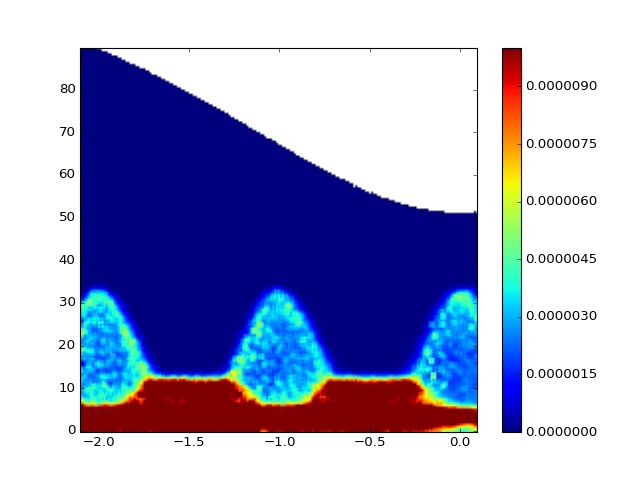

In [57]:
H.plot(hh.load("./slice_H00_-2,0.h5"), min=0, max=1e-5)